In [1]:
import numpy as np
import tensorflow as tf
import Loader
import Transformer

C:\Users\Lemon\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)

### Notes on Principal Component Analysis

Does it make sense to run PCA on like-type parts of the data?
As there are clearly different "sets" of the data per row.

In [4]:
#for i in range(len(labelsTrain)):
#    print(i, '\b:\t', labelsTrain[i], compoundDataTrain[35:40, i])
    
#for all the following ranges begin is inclusive and end is not inclusive
#[0:10] docking_score_? (0-9)
#[10:20] fusion_score_? (0-9)
#[37:45] bcut2d_? (8 in total)
#[47:59] chi? (12, odd labels)
#[65:79] paoe_vsa? (1-14)
#[79:89] smr_vsa? (1-10)
#[89:101] slogp_vsa? (1-12)
#[102:113] estate_vsa? (1-11)
#[113:123] vsa_estate? (1-10)
#[143:228] fr_some_chemical? (85 total)

#print(labelsTrain[0:10],"\n")
#print(labelsTrain[10:20],"\n")
#print(labelsTrain[37:45],"\n")
#print(labelsTrain[47:59],"\n")
#print(labelsTrain[65:79],"\n")
#print(labelsTrain[79:89],"\n")
#print(labelsTrain[89:101],"\n")
#print(labelsTrain[102:113],"\n")
#print(labelsTrain[113:123],"\n")
#print(labelsTrain[143:228],"\n")

## Data Preprocessing
PCA, modify fusion/docking, normalization

### Apply Principal Component Analysis

In [10]:
#reduce dimension through PCA
#in order endDims sections are chi, paoe, smr, slogp, estate_vsa, vsa_estate, fr
labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  compoundDataTrain, 
                                                            compoundDataTest, compoundDataValidate,
                                                            endDims=[1,1,4,4,3,3,3,3])
print("PCA done, new dimensions:", len(labelsPCA))

bcut2d retention: [0.99364773]
	total: 99.36477273412324%
chi retention: [0.9541968]
	total: 95.41967968597899%
paoe retention: [0.31495127 0.19509321 0.1390042  0.08838179]
	total: 73.74304791821297%
smr retention: [0.50634726 0.24568468 0.08792319 0.07435827]
	total: 91.43133907840088%
slogp retention: [0.44620276 0.22134465 0.15753302]
	total: 82.50804204396243%
estate_vsa retention: [0.29224011 0.18964809 0.14361318]
	total: 62.550138683064425%
vsa_estate retention: [0.49255304 0.32866098 0.09719245]
	total: 91.84064669216781%
fr retention: [0.32153498 0.12578177 0.09944384]
	total: 54.67605936051208%
PCA done, new dimensions: 88


### Use either mean or max magnitude of docking and fusion

Actually quite similar e.g. for the first 3 rows:

fusion max:  $[5.3211, 5.3258, 5.3936]$

fusion avg:  $[5.0530, 5.2303, 5.1805]$

docking max: $[6.7, 7.2, 7.3]$

docking avg: $[-6.51, -6.92, -7.18]$

In [52]:
#use mean of the docking and fusion
labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
_, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
_, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)
print("Mean of Fusion and Docking, new dimensions: ", len(labelsMeanPCA))

Mean of Fusion and Docking, new dimensions:  70


In [13]:
#use max magnitude of the docking and fusion
labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
_, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
_, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)
print("Max of Fusion and Docking, new dimensions: ", len(labelsMeanPCA))

Max of Fusion and Docking, new dimensions:  70


### Assign final data and normalize data

In [61]:
#after transformations are done assign data
dataLabels = labelsMeanPCA
trainData = trainMeanPCA
testData = testMeanPCA
valData = valMeanPCA

trainData, testData, valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)

## See modified labels and example data:

In [55]:
print(np.shape(trainData))
for i in range(len(dataLabels)):
    print(i, "\b:\t", dataLabels[i], "\t", trainData[0:3,i])

#0:	 fusion_score_max 	 [6.7 7.2 7.3]
#1:	 docking_score_max 	 [5.32109785 5.32583714 5.39357948]

#0:	 fusion_score_average 	 [-6.51 -6.92 -7.18]
#1:	 docking_score_average 	 [5.05295382 5.2303369  5.1805407 ]

(2717, 70)
0 :	 docking_score_average 	 [-7.45 -5.27 -6.89]
1 :	 fusion_score_average 	 [4.70133185 4.37893329 5.03581705]
2 :	 maxestateindex 	 [13.33612248 13.26439532 13.57126317]
3 :	 minestateindex 	 [-3.61530057 -2.03494271 -0.54534029]
4 :	 maxabsestateindex 	 [13.33612248 13.26439532 13.57126317]
5 :	 minabsestateindex 	 [0.01008786 0.00721249 0.04428773]
6 :	 qed 	 [0.52948475 0.06054508 0.88855726]
7 :	 molwt 	 [558.682 754.735 374.412]
8 :	 heavyatommolwt 	 [528.442 708.367 351.228]
9 :	 exactmolwt 	 [558.16067668 754.26841463 374.16418544]
10 :	 numvalenceelectrons 	 [202. 294. 144.]
11 :	 numradicalelectrons 	 [0. 0. 0.]
12 :	 maxpartialcharge 	 [0.24272788 0.33073297 0.25189738]
13 :	 minpartialcharge 	 [-0.37871066 -0.50425989 -0.38102961]
14 :	 maxabspartialcharge 	 [0.37871066 0.50425989 0.38102961]
15 :	 minabspartialcharge 	 [0.24272788 0.33073297 0.25189738]
16 :	 fpdensitymorgan1 	 [1.05263158 0.86792453 1.48148148]
17 :	 fpdensitymorgan2 	 [1.789

# Apply NN

In [16]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError

In [56]:
#note the constant guess:
classify = Transformer.toClassification(activitiesTrain)
constantGuess = (len(classify[classify == 1]))/len(classify)
print(constantGuess)

0.6198012513801987


In [78]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-2,
    decay_steps=10000,
    decay_rate=1)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

l1Reg = 1e-10

model = Sequential()
model.add(Dense(np.shape(trainData)[1], input_dim=np.shape(trainData)[1], activation='tanh', 
                kernel_regularizer = keras.regularizers.L2(l1Reg)))
model.add(Dense(100, activation='leaky_relu', kernel_regularizer = keras.regularizers.L1()))
model.add(Dense(120, activation='leaky_relu', kernel_regularizer = keras.regularizers.L1(l1Reg)))
model.add(Dense(140, activation='tanh', kernel_regularizer = keras.regularizers.L1(l1Reg)))
model.add(Dense(120, activation='leaky_relu', kernel_regularizer = keras.regularizers.L1(l1Reg)))
model.add(Dense(80, activation='tanh', kernel_regularizer = keras.regularizers.L1(l1Reg)))
model.add(Dense(40, activation='relu', kernel_regularizer = keras.regularizers.L1(l1Reg)))
model.add(Dense(20, activation='relu', kernel_regularizer = keras.regularizers.L1(l1Reg)))
model.add(Dense(5, activation='relu', kernel_regularizer = keras.regularizers.L1(l1Reg)))
model.add(Dense(1, activation='tanh', kernel_regularizer = keras.regularizers.L1(l1Reg)))

model.compile(loss='MeanSquaredError', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(trainData, Transformer.toClassification(activitiesTrain), 
                    validation_data = (valData, Transformer.toClassification(activitiesValidate)), epochs=1600, batch_size=8)

Epoch 1/1600
340/340 [==============================] - 3s 4ms/step - loss: 4.3204 - accuracy: 0.3360 - val_loss: 1.9879 - val_accuracy: 0.5147
Epoch 2/1600
340/340 [==============================] - 1s 2ms/step - loss: 1.0831 - accuracy: 0.4818 - val_loss: 0.6619 - val_accuracy: 0.4176
Epoch 3/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.6318 - accuracy: 0.4914 - val_loss: 0.6092 - val_accuracy: 0.4618
Epoch 4/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.5554 - accuracy: 0.4969 - val_loss: 0.5113 - val_accuracy: 0.4941
Epoch 5/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.5129 - accuracy: 0.5112 - val_loss: 0.5031 - val_accuracy: 0.4971
Epoch 6/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.4783 - accuracy: 0.5120 - val_loss: 0.4773 - val_accuracy: 0.5176
Epoch 7/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.4783 - accuracy: 0.5197 - val_loss: 0.5853 - val_accuracy:

340/340 [==============================] - 1s 3ms/step - loss: 0.2734 - accuracy: 0.5727 - val_loss: 0.4305 - val_accuracy: 0.5294
Epoch 58/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.2516 - accuracy: 0.5793 - val_loss: 0.5491 - val_accuracy: 0.5265
Epoch 59/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.2810 - accuracy: 0.5745 - val_loss: 0.4215 - val_accuracy: 0.5294
Epoch 60/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.2518 - accuracy: 0.5778 - val_loss: 0.4500 - val_accuracy: 0.5382
Epoch 61/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.2731 - accuracy: 0.5793 - val_loss: 0.4496 - val_accuracy: 0.5324
Epoch 62/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.2588 - accuracy: 0.5789 - val_loss: 0.4819 - val_accuracy: 0.5353
Epoch 63/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.2738 - accuracy: 0.5756 - val_loss: 0.4985 - val_accuracy: 0.5265

340/340 [==============================] - 1s 2ms/step - loss: 0.2283 - accuracy: 0.5922 - val_loss: 0.4846 - val_accuracy: 0.5471
Epoch 114/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.2321 - accuracy: 0.5926 - val_loss: 0.4797 - val_accuracy: 0.5294
Epoch 115/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.2230 - accuracy: 0.5881 - val_loss: 0.4497 - val_accuracy: 0.5412
Epoch 116/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.2165 - accuracy: 0.5915 - val_loss: 0.4416 - val_accuracy: 0.5618
Epoch 117/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.2202 - accuracy: 0.5918 - val_loss: 0.5457 - val_accuracy: 0.5559
Epoch 118/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.2191 - accuracy: 0.5922 - val_loss: 0.4874 - val_accuracy: 0.5500
Epoch 119/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.2064 - accuracy: 0.5933 - val_loss: 0.4814 - val_accuracy: 

340/340 [==============================] - 1s 3ms/step - loss: 0.1968 - accuracy: 0.5966 - val_loss: 0.4420 - val_accuracy: 0.5441
Epoch 170/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1717 - accuracy: 0.6018 - val_loss: 0.4903 - val_accuracy: 0.5500
Epoch 171/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1880 - accuracy: 0.5959 - val_loss: 0.5000 - val_accuracy: 0.5412
Epoch 172/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1842 - accuracy: 0.5970 - val_loss: 0.4519 - val_accuracy: 0.5529
Epoch 173/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1961 - accuracy: 0.5966 - val_loss: 0.4665 - val_accuracy: 0.5441
Epoch 174/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1911 - accuracy: 0.5974 - val_loss: 0.5416 - val_accuracy: 0.5206
Epoch 175/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1859 - accuracy: 0.5962 - val_loss: 0.4849 - val_accuracy: 

340/340 [==============================] - 1s 2ms/step - loss: 0.1812 - accuracy: 0.6007 - val_loss: 0.4942 - val_accuracy: 0.5235
Epoch 226/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1775 - accuracy: 0.5985 - val_loss: 0.4420 - val_accuracy: 0.5588
Epoch 227/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1630 - accuracy: 0.6036 - val_loss: 0.4480 - val_accuracy: 0.5441
Epoch 228/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1840 - accuracy: 0.5988 - val_loss: 0.4226 - val_accuracy: 0.5382
Epoch 229/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1507 - accuracy: 0.6032 - val_loss: 0.4506 - val_accuracy: 0.5471
Epoch 230/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1873 - accuracy: 0.6007 - val_loss: 0.4803 - val_accuracy: 0.5353
Epoch 231/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1659 - accuracy: 0.5996 - val_loss: 0.4435 - val_accuracy: 

340/340 [==============================] - 1s 2ms/step - loss: 0.1558 - accuracy: 0.6047 - val_loss: 0.4816 - val_accuracy: 0.5471
Epoch 282/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1862 - accuracy: 0.5985 - val_loss: 0.4646 - val_accuracy: 0.5500
Epoch 283/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1747 - accuracy: 0.6029 - val_loss: 0.4253 - val_accuracy: 0.5559
Epoch 284/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1607 - accuracy: 0.6043 - val_loss: 0.4257 - val_accuracy: 0.5618
Epoch 285/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1573 - accuracy: 0.6047 - val_loss: 0.4430 - val_accuracy: 0.5529
Epoch 286/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1710 - accuracy: 0.6014 - val_loss: 0.4762 - val_accuracy: 0.5382
Epoch 287/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1836 - accuracy: 0.6018 - val_loss: 0.4488 - val_accuracy: 

340/340 [==============================] - 1s 2ms/step - loss: 0.1325 - accuracy: 0.6099 - val_loss: 0.3995 - val_accuracy: 0.5676
Epoch 338/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1486 - accuracy: 0.6058 - val_loss: 0.3928 - val_accuracy: 0.5706
Epoch 339/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1494 - accuracy: 0.6069 - val_loss: 0.4843 - val_accuracy: 0.5324
Epoch 340/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1652 - accuracy: 0.6058 - val_loss: 0.4544 - val_accuracy: 0.5353
Epoch 341/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1301 - accuracy: 0.6102 - val_loss: 0.4001 - val_accuracy: 0.5706
Epoch 342/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1718 - accuracy: 0.6047 - val_loss: 0.4920 - val_accuracy: 0.5412
Epoch 343/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1446 - accuracy: 0.6102 - val_loss: 0.4633 - val_accuracy: 

340/340 [==============================] - 1s 2ms/step - loss: 0.1806 - accuracy: 0.6021 - val_loss: 0.4768 - val_accuracy: 0.5441
Epoch 394/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1483 - accuracy: 0.6080 - val_loss: 0.4287 - val_accuracy: 0.5500
Epoch 395/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1425 - accuracy: 0.6080 - val_loss: 0.4255 - val_accuracy: 0.5382
Epoch 396/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1488 - accuracy: 0.6058 - val_loss: 0.4905 - val_accuracy: 0.5500
Epoch 397/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1563 - accuracy: 0.6047 - val_loss: 0.5115 - val_accuracy: 0.5471
Epoch 398/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1106 - accuracy: 0.6106 - val_loss: 0.4240 - val_accuracy: 0.5500
Epoch 399/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1971 - accuracy: 0.5992 - val_loss: 0.4504 - val_accuracy: 

340/340 [==============================] - 1s 2ms/step - loss: 0.1646 - accuracy: 0.6040 - val_loss: 0.4575 - val_accuracy: 0.5588
Epoch 450/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1589 - accuracy: 0.6073 - val_loss: 0.4403 - val_accuracy: 0.5529
Epoch 451/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1461 - accuracy: 0.6058 - val_loss: 0.4994 - val_accuracy: 0.5382
Epoch 452/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1633 - accuracy: 0.6077 - val_loss: 0.4426 - val_accuracy: 0.5618
Epoch 453/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1456 - accuracy: 0.6088 - val_loss: 0.4603 - val_accuracy: 0.5324
Epoch 454/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1257 - accuracy: 0.6102 - val_loss: 0.3923 - val_accuracy: 0.5618
Epoch 455/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1835 - accuracy: 0.6040 - val_loss: 0.4819 - val_accuracy: 

340/340 [==============================] - 1s 2ms/step - loss: 0.2044 - accuracy: 0.5985 - val_loss: 0.5012 - val_accuracy: 0.5588
Epoch 506/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1742 - accuracy: 0.6054 - val_loss: 0.4758 - val_accuracy: 0.5471
Epoch 507/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1502 - accuracy: 0.6099 - val_loss: 0.4425 - val_accuracy: 0.5412
Epoch 508/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1280 - accuracy: 0.6117 - val_loss: 0.4883 - val_accuracy: 0.5294
Epoch 509/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1635 - accuracy: 0.6054 - val_loss: 0.5022 - val_accuracy: 0.5559
Epoch 510/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1492 - accuracy: 0.6080 - val_loss: 0.4319 - val_accuracy: 0.5471
Epoch 511/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1250 - accuracy: 0.6106 - val_loss: 0.4491 - val_accuracy: 

340/340 [==============================] - 1s 2ms/step - loss: 0.1386 - accuracy: 0.6110 - val_loss: 0.4302 - val_accuracy: 0.5353
Epoch 562/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1434 - accuracy: 0.6047 - val_loss: 0.4931 - val_accuracy: 0.5471
Epoch 563/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1338 - accuracy: 0.6102 - val_loss: 0.4904 - val_accuracy: 0.5441
Epoch 564/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1466 - accuracy: 0.6088 - val_loss: 0.4843 - val_accuracy: 0.5529
Epoch 565/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1264 - accuracy: 0.6102 - val_loss: 0.3822 - val_accuracy: 0.5559
Epoch 566/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1533 - accuracy: 0.6047 - val_loss: 0.4678 - val_accuracy: 0.5529
Epoch 567/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1508 - accuracy: 0.6080 - val_loss: 0.4512 - val_accuracy: 

340/340 [==============================] - 1s 2ms/step - loss: 0.1377 - accuracy: 0.6069 - val_loss: 0.4609 - val_accuracy: 0.5500
Epoch 618/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1443 - accuracy: 0.6073 - val_loss: 0.3894 - val_accuracy: 0.5529
Epoch 619/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1410 - accuracy: 0.6069 - val_loss: 0.4566 - val_accuracy: 0.5618
Epoch 620/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1442 - accuracy: 0.6066 - val_loss: 0.4338 - val_accuracy: 0.5559
Epoch 621/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1200 - accuracy: 0.6117 - val_loss: 0.4070 - val_accuracy: 0.5412
Epoch 622/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1573 - accuracy: 0.6058 - val_loss: 0.4727 - val_accuracy: 0.5676
Epoch 623/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1304 - accuracy: 0.6099 - val_loss: 0.4299 - val_accuracy: 

340/340 [==============================] - 1s 3ms/step - loss: 0.1437 - accuracy: 0.6058 - val_loss: 0.4654 - val_accuracy: 0.5529
Epoch 674/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1182 - accuracy: 0.6117 - val_loss: 0.4017 - val_accuracy: 0.5529
Epoch 675/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1474 - accuracy: 0.6040 - val_loss: 0.4738 - val_accuracy: 0.5412
Epoch 676/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1460 - accuracy: 0.6095 - val_loss: 0.4306 - val_accuracy: 0.5500
Epoch 677/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1445 - accuracy: 0.6084 - val_loss: 0.4017 - val_accuracy: 0.5618
Epoch 678/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1169 - accuracy: 0.6099 - val_loss: 0.5013 - val_accuracy: 0.5676
Epoch 679/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1424 - accuracy: 0.6084 - val_loss: 0.3972 - val_accuracy: 

340/340 [==============================] - 1s 2ms/step - loss: 0.1307 - accuracy: 0.6069 - val_loss: 0.5470 - val_accuracy: 0.5324
Epoch 730/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1341 - accuracy: 0.6088 - val_loss: 0.4398 - val_accuracy: 0.5529
Epoch 731/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1285 - accuracy: 0.6080 - val_loss: 0.4598 - val_accuracy: 0.5559
Epoch 732/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1139 - accuracy: 0.6084 - val_loss: 0.4402 - val_accuracy: 0.5412
Epoch 733/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1281 - accuracy: 0.6084 - val_loss: 0.4555 - val_accuracy: 0.5471
Epoch 734/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1441 - accuracy: 0.6069 - val_loss: 0.4990 - val_accuracy: 0.5529
Epoch 735/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1302 - accuracy: 0.6106 - val_loss: 0.5431 - val_accuracy: 

340/340 [==============================] - 1s 3ms/step - loss: 0.1501 - accuracy: 0.6073 - val_loss: 0.5102 - val_accuracy: 0.5588
Epoch 786/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1521 - accuracy: 0.6091 - val_loss: 0.4612 - val_accuracy: 0.5529
Epoch 787/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1202 - accuracy: 0.6124 - val_loss: 0.4291 - val_accuracy: 0.5529
Epoch 788/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1032 - accuracy: 0.6124 - val_loss: 0.4337 - val_accuracy: 0.5382
Epoch 789/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1500 - accuracy: 0.6058 - val_loss: 0.4671 - val_accuracy: 0.5529
Epoch 790/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1387 - accuracy: 0.6062 - val_loss: 0.5071 - val_accuracy: 0.5382
Epoch 791/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1442 - accuracy: 0.6091 - val_loss: 0.4994 - val_accuracy: 

340/340 [==============================] - 1s 2ms/step - loss: 0.1437 - accuracy: 0.6091 - val_loss: 0.4922 - val_accuracy: 0.5618
Epoch 842/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1092 - accuracy: 0.6132 - val_loss: 0.4118 - val_accuracy: 0.5500
Epoch 843/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1344 - accuracy: 0.6080 - val_loss: 0.4926 - val_accuracy: 0.5588
Epoch 844/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1436 - accuracy: 0.6080 - val_loss: 0.4872 - val_accuracy: 0.5735
Epoch 845/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1359 - accuracy: 0.6106 - val_loss: 0.4672 - val_accuracy: 0.5559
Epoch 846/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1298 - accuracy: 0.6099 - val_loss: 0.5109 - val_accuracy: 0.5676
Epoch 847/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1316 - accuracy: 0.6102 - val_loss: 0.4271 - val_accuracy: 

340/340 [==============================] - 1s 2ms/step - loss: 0.1570 - accuracy: 0.6084 - val_loss: 0.4837 - val_accuracy: 0.5559
Epoch 898/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1316 - accuracy: 0.6091 - val_loss: 0.4669 - val_accuracy: 0.5647
Epoch 899/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1414 - accuracy: 0.6069 - val_loss: 0.4719 - val_accuracy: 0.5353
Epoch 900/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1114 - accuracy: 0.6117 - val_loss: 0.4040 - val_accuracy: 0.5559
Epoch 901/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1396 - accuracy: 0.6084 - val_loss: 0.5331 - val_accuracy: 0.5588
Epoch 902/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1555 - accuracy: 0.6088 - val_loss: 0.4284 - val_accuracy: 0.5412
Epoch 903/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1175 - accuracy: 0.6099 - val_loss: 0.4727 - val_accuracy: 

340/340 [==============================] - 1s 2ms/step - loss: 0.1042 - accuracy: 0.6139 - val_loss: 0.4190 - val_accuracy: 0.5471
Epoch 954/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1330 - accuracy: 0.6029 - val_loss: 0.8855 - val_accuracy: 0.5176
Epoch 955/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1374 - accuracy: 0.6099 - val_loss: 0.4832 - val_accuracy: 0.5500
Epoch 956/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1552 - accuracy: 0.6058 - val_loss: 0.4879 - val_accuracy: 0.5500
Epoch 957/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1172 - accuracy: 0.6132 - val_loss: 0.4559 - val_accuracy: 0.5559
Epoch 958/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1475 - accuracy: 0.6084 - val_loss: 0.4627 - val_accuracy: 0.5588
Epoch 959/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1154 - accuracy: 0.6128 - val_loss: 0.4636 - val_accuracy: 

340/340 [==============================] - 1s 2ms/step - loss: 0.1100 - accuracy: 0.6143 - val_loss: 0.4067 - val_accuracy: 0.5529
Epoch 1010/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1454 - accuracy: 0.6069 - val_loss: 0.5843 - val_accuracy: 0.5471
Epoch 1011/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1471 - accuracy: 0.6080 - val_loss: 0.4166 - val_accuracy: 0.5647
Epoch 1012/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1700 - accuracy: 0.6029 - val_loss: 0.4680 - val_accuracy: 0.5529
Epoch 1013/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1663 - accuracy: 0.6054 - val_loss: 0.4458 - val_accuracy: 0.5559
Epoch 1014/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1329 - accuracy: 0.6091 - val_loss: 0.3757 - val_accuracy: 0.5735
Epoch 1015/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1257 - accuracy: 0.6106 - val_loss: 0.4158 - val_accu

Epoch 1065/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1221 - accuracy: 0.6091 - val_loss: 0.4272 - val_accuracy: 0.5500
Epoch 1066/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1215 - accuracy: 0.6110 - val_loss: 0.4342 - val_accuracy: 0.5353
Epoch 1067/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.0869 - accuracy: 0.6146 - val_loss: 0.4231 - val_accuracy: 0.5647
Epoch 1068/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1550 - accuracy: 0.6077 - val_loss: 0.6011 - val_accuracy: 0.5118
Epoch 1069/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1367 - accuracy: 0.6091 - val_loss: 0.4195 - val_accuracy: 0.5471
Epoch 1070/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.0958 - accuracy: 0.6113 - val_loss: 0.4750 - val_accuracy: 0.5588
Epoch 1071/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1673 - accuracy: 0.6043 - val_loss: 0

Epoch 1121/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1255 - accuracy: 0.6110 - val_loss: 0.6336 - val_accuracy: 0.5824
Epoch 1122/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1077 - accuracy: 0.6135 - val_loss: 0.4117 - val_accuracy: 0.5588
Epoch 1123/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1405 - accuracy: 0.6088 - val_loss: 0.4642 - val_accuracy: 0.5529
Epoch 1124/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1868 - accuracy: 0.5999 - val_loss: 0.5434 - val_accuracy: 0.5412
Epoch 1125/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1329 - accuracy: 0.6099 - val_loss: 0.5353 - val_accuracy: 0.5500
Epoch 1126/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1292 - accuracy: 0.6110 - val_loss: 0.4656 - val_accuracy: 0.5471
Epoch 1127/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1136 - accuracy: 0.6113 - val_loss: 0

Epoch 1177/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1379 - accuracy: 0.6069 - val_loss: 0.4603 - val_accuracy: 0.5618
Epoch 1178/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1257 - accuracy: 0.6106 - val_loss: 0.4510 - val_accuracy: 0.5529
Epoch 1179/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1250 - accuracy: 0.6106 - val_loss: 0.4871 - val_accuracy: 0.5559
Epoch 1180/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1538 - accuracy: 0.6058 - val_loss: 0.4553 - val_accuracy: 0.5676
Epoch 1181/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1055 - accuracy: 0.6124 - val_loss: 0.4501 - val_accuracy: 0.5618
Epoch 1182/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1428 - accuracy: 0.6091 - val_loss: 0.4693 - val_accuracy: 0.5441
Epoch 1183/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1054 - accuracy: 0.6132 - val_loss: 0

Epoch 1233/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1093 - accuracy: 0.6124 - val_loss: 1.1473 - val_accuracy: 0.4824
Epoch 1234/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1548 - accuracy: 0.6069 - val_loss: 0.4850 - val_accuracy: 0.5441
Epoch 1235/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1198 - accuracy: 0.6128 - val_loss: 0.4575 - val_accuracy: 0.5559
Epoch 1236/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1076 - accuracy: 0.6106 - val_loss: 0.4529 - val_accuracy: 0.5647
Epoch 1237/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1453 - accuracy: 0.6066 - val_loss: 0.4445 - val_accuracy: 0.5618
Epoch 1238/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1389 - accuracy: 0.6095 - val_loss: 0.5252 - val_accuracy: 0.5559
Epoch 1239/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1160 - accuracy: 0.6135 - val_loss: 0

Epoch 1289/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.0969 - accuracy: 0.6139 - val_loss: 0.4293 - val_accuracy: 0.5441
Epoch 1290/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1150 - accuracy: 0.6106 - val_loss: 0.4558 - val_accuracy: 0.5588
Epoch 1291/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1353 - accuracy: 0.6091 - val_loss: 0.3974 - val_accuracy: 0.5647
Epoch 1292/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.0960 - accuracy: 0.6143 - val_loss: 0.3802 - val_accuracy: 0.5588
Epoch 1293/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1604 - accuracy: 0.6069 - val_loss: 0.4341 - val_accuracy: 0.5529
Epoch 1294/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1008 - accuracy: 0.6139 - val_loss: 0.4241 - val_accuracy: 0.5500
Epoch 1295/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1402 - accuracy: 0.6088 - val_loss: 0

Epoch 1345/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.0992 - accuracy: 0.6146 - val_loss: 0.4056 - val_accuracy: 0.5588
Epoch 1346/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.0999 - accuracy: 0.6132 - val_loss: 0.3896 - val_accuracy: 0.5647
Epoch 1347/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1440 - accuracy: 0.6091 - val_loss: 0.4500 - val_accuracy: 0.5441
Epoch 1348/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1079 - accuracy: 0.6124 - val_loss: 0.4124 - val_accuracy: 0.5618
Epoch 1349/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1328 - accuracy: 0.6077 - val_loss: 0.4550 - val_accuracy: 0.5471
Epoch 1350/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1058 - accuracy: 0.6121 - val_loss: 0.4243 - val_accuracy: 0.5529
Epoch 1351/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1420 - accuracy: 0.6066 - val_loss: 0

Epoch 1401/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1001 - accuracy: 0.6135 - val_loss: 0.4249 - val_accuracy: 0.5500
Epoch 1402/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1662 - accuracy: 0.6054 - val_loss: 0.4638 - val_accuracy: 0.5559
Epoch 1403/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1367 - accuracy: 0.6099 - val_loss: 0.4503 - val_accuracy: 0.5588
Epoch 1404/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.0989 - accuracy: 0.6143 - val_loss: 0.4753 - val_accuracy: 0.5559
Epoch 1405/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1442 - accuracy: 0.6088 - val_loss: 0.4452 - val_accuracy: 0.5412
Epoch 1406/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1057 - accuracy: 0.6139 - val_loss: 0.3994 - val_accuracy: 0.5588
Epoch 1407/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1190 - accuracy: 0.6095 - val_loss: 0

Epoch 1457/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1289 - accuracy: 0.6110 - val_loss: 0.4497 - val_accuracy: 0.5500
Epoch 1458/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1274 - accuracy: 0.6088 - val_loss: 0.4501 - val_accuracy: 0.5529
Epoch 1459/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1141 - accuracy: 0.6110 - val_loss: 0.5686 - val_accuracy: 0.5676
Epoch 1460/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1537 - accuracy: 0.6091 - val_loss: 0.4623 - val_accuracy: 0.5412
Epoch 1461/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1033 - accuracy: 0.6139 - val_loss: 0.4082 - val_accuracy: 0.5471
Epoch 1462/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1064 - accuracy: 0.6095 - val_loss: 0.4542 - val_accuracy: 0.5647
Epoch 1463/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1337 - accuracy: 0.6102 - val_loss: 0

Epoch 1513/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1210 - accuracy: 0.6110 - val_loss: 0.4074 - val_accuracy: 0.5647
Epoch 1514/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1348 - accuracy: 0.6080 - val_loss: 0.4685 - val_accuracy: 0.5529
Epoch 1515/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1080 - accuracy: 0.6132 - val_loss: 0.3997 - val_accuracy: 0.5500
Epoch 1516/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1224 - accuracy: 0.6099 - val_loss: 0.4299 - val_accuracy: 0.5588
Epoch 1517/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1112 - accuracy: 0.6124 - val_loss: 0.4757 - val_accuracy: 0.5471
Epoch 1518/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1678 - accuracy: 0.6054 - val_loss: 0.5179 - val_accuracy: 0.5588
Epoch 1519/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1629 - accuracy: 0.6091 - val_loss: 0

Epoch 1569/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1066 - accuracy: 0.6150 - val_loss: 0.4297 - val_accuracy: 0.5559
Epoch 1570/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1110 - accuracy: 0.6106 - val_loss: 0.4541 - val_accuracy: 0.5529
Epoch 1571/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1244 - accuracy: 0.6095 - val_loss: 0.4890 - val_accuracy: 0.5412
Epoch 1572/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1259 - accuracy: 0.6110 - val_loss: 0.4981 - val_accuracy: 0.5529
Epoch 1573/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1210 - accuracy: 0.6113 - val_loss: 0.4572 - val_accuracy: 0.5471
Epoch 1574/1600
340/340 [==============================] - 1s 2ms/step - loss: 0.1018 - accuracy: 0.6135 - val_loss: 0.4052 - val_accuracy: 0.5559
Epoch 1575/1600
340/340 [==============================] - 1s 3ms/step - loss: 0.1049 - accuracy: 0.6128 - val_loss: 0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


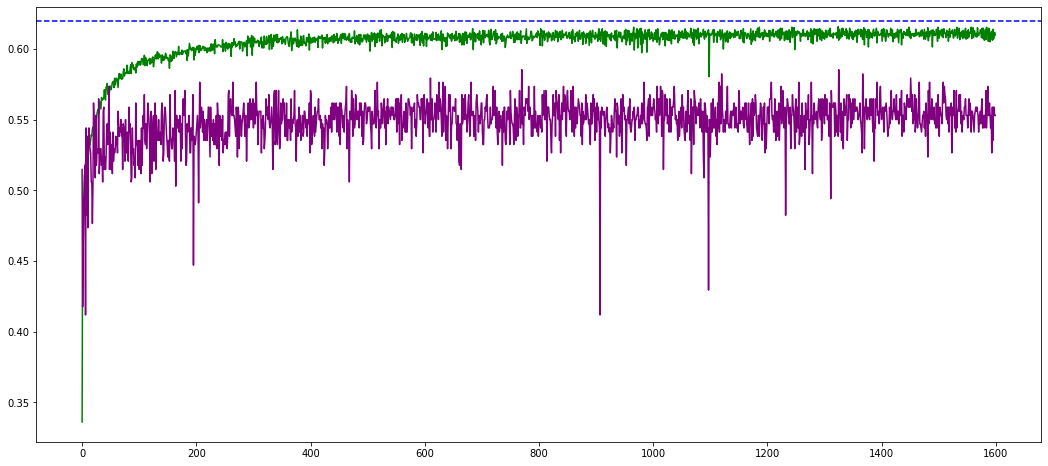

In [79]:
import matplotlib.pyplot as plt

print(history.history.keys())

classify = Transformer.toClassification(activitiesTrain)
constantGuess = (len(classify[classify == 1]))/len(classify)


fig, ax = plt.subplots(figsize=(18,8))

ax.plot(history.history["accuracy"], color="green")
ax.plot(history.history["val_accuracy"], color="purple")
ax.axhline(constantGuess, color="blue", linestyle="dashed")

In [73]:
classData = Transformer.toClassification(activitiesTrain)
print(len(trainData))
print(len(classData[classData == 1]))
print(len(classData[classData != 1]))

2717
1684
1033
